In [2]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

In [3]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df["dist_km"] = haversine_distance(df, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")
df.head()

df["pickup_datetime"] = pd.to_datetime(df.pickup_datetime)
df["EDTdate"] = df.pickup_datetime - pd.Timedelta(hours=4)
df["hour"] = df["EDTdate"].dt.hour
df["AMorPM"] = np.where(df["hour"] < 12, 'am', 'pm')
df["weekday"] = df["EDTdate"].dt.strftime("%a")

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,hour,AMorPM,weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [55]:
cat_cols = ["hour", "AMorPM", "weekday"]
cont_cols = ['pickup_latitude', 'pickup_longitude'
       , 'dropoff_latitude', 'dropoff_longitude',
       'passenger_count', 'dist_km']
y_col = ["fare_class"]

In [56]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [57]:
cats = np.stack([df[cat].cat.codes.values for cat in cat_cols],axis=1)
cats = torch.tensor(cats, dtype=torch.int64)
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [58]:
conts = np.stack([df[cont].values for cont in cont_cols], axis=1 )
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        ...,
        [ 40.7498, -73.9886,  40.7078, -74.0115,   3.0000,   5.0525],
        [ 40.7245, -74.0044,  40.7308, -73.9927,   1.0000,   1.2089],
        [ 40.7719, -73.9554,  40.7630, -73.9676,   3.0000,   1.4274]])

In [59]:
y = torch.tensor(df[y_col].values).flatten()
y

tensor([0, 0, 1,  ..., 1, 0, 0])

In [60]:
cat_sizes = [ len(df[col].cat.categories) for col in cat_cols]
cat_sizes

[24, 2, 7]

In [61]:
emb_sizes = [(size,min(50,(size +1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [62]:
catz = cats[:2]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [63]:
selfEmbeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
selfEmbeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [64]:
embeddingz = []

for i, e in enumerate(selfEmbeds):
    embeddingz.append(e(catz[:,1]))

embeddingz

[tensor([[-1.0362,  2.1876,  1.8276, -0.6572, -1.3853,  1.5106,  0.3245, -0.8968,
           0.2415, -1.2423, -1.0291, -0.0700],
         [-1.0362,  2.1876,  1.8276, -0.6572, -1.3853,  1.5106,  0.3245, -0.8968,
           0.2415, -1.2423, -1.0291, -0.0700]], grad_fn=<EmbeddingBackward0>),
 tensor([[1.6579],
         [1.6579]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.0153,  0.6333, -1.0332,  0.2517],
         [-0.0153,  0.6333, -1.0332,  0.2517]], grad_fn=<EmbeddingBackward0>)]

In [65]:
z = torch.cat(embeddingz,1)
z

tensor([[-1.0362,  2.1876,  1.8276, -0.6572, -1.3853,  1.5106,  0.3245, -0.8968,
          0.2415, -1.2423, -1.0291, -0.0700,  1.6579, -0.0153,  0.6333, -1.0332,
          0.2517],
        [-1.0362,  2.1876,  1.8276, -0.6572, -1.3853,  1.5106,  0.3245, -0.8968,
          0.2415, -1.2423, -1.0291, -0.0700,  1.6579, -0.0153,  0.6333, -1.0332,
          0.2517]], grad_fn=<CatBackward0>)

In [66]:
self_emb_drop = nn.Dropout(0.4)
z = self_emb_drop(z)
z

tensor([[-1.7269,  0.0000,  3.0460, -0.0000, -0.0000,  2.5176,  0.5408, -1.4947,
          0.0000, -0.0000, -1.7152, -0.1167,  2.7632, -0.0255,  0.0000, -1.7220,
          0.0000],
        [-1.7269,  3.6460,  0.0000, -0.0000, -2.3089,  2.5176,  0.0000, -0.0000,
          0.0000, -0.0000, -1.7152, -0.0000,  0.0000, -0.0255,  1.0556, -1.7220,
          0.4195]], grad_fn=<MulBackward0>)

In [67]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_embs = sum(nf for ni, nf in emb_sizes)
        n_in = n_embs + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        
        return x
        
        

In [68]:
torch.manual_seed(33)
#output size is set to how many outputs we have
model = TabularModel(emb_sizes, conts.shape[1], 2, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [69]:
#compared to regressional analysis we will use cross entropy loss instead of MSEL

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [70]:
batch_size = 60000
test_size = int(batch_size*0.2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [71]:
y_train

tensor([0, 0, 1,  ..., 0, 0, 1])

In [72]:
start_time = time.time()

epochs = 300

losses = []

for i in range(epochs):
    i += 1
    
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i%10==0:
        print(f'epoch: {i}, loss: {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 10, loss: 0.7067696452140808
epoch: 20, loss: 0.6320292353630066
epoch: 30, loss: 0.6038127541542053
epoch: 40, loss: 0.5878072381019592
epoch: 50, loss: 0.576866865158081
epoch: 60, loss: 0.5668488144874573
epoch: 70, loss: 0.5602366328239441
epoch: 80, loss: 0.5545040965080261
epoch: 90, loss: 0.5485873818397522
epoch: 100, loss: 0.5464335680007935
epoch: 110, loss: 0.5423245429992676
epoch: 120, loss: 0.539663553237915
epoch: 130, loss: 0.5363161563873291
epoch: 140, loss: 0.532609224319458
epoch: 150, loss: 0.5311216115951538
epoch: 160, loss: 0.5282803177833557
epoch: 170, loss: 0.5277610421180725
epoch: 180, loss: 0.5252001881599426
epoch: 190, loss: 0.5231755375862122
epoch: 200, loss: 0.519977331161499
epoch: 210, loss: 0.5177479982376099
epoch: 220, loss: 0.516769289970398
epoch: 230, loss: 0.51348876953125
epoch: 240, loss: 0.5121244192123413
epoch: 250, loss: 0.5109508037567139
epoch: 260, loss: 0.5081547498703003
epoch: 270, loss: 0.5072288513183594
epoch: 280, loss:

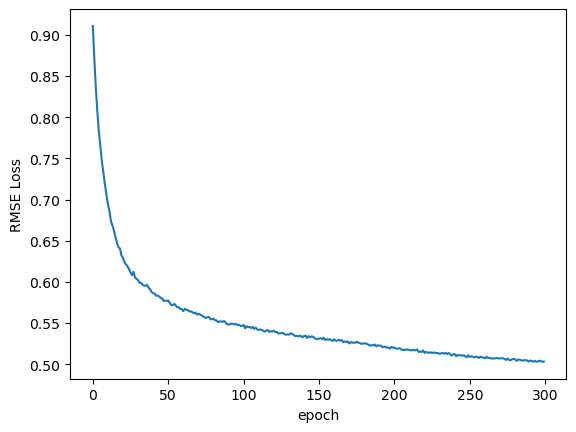

In [76]:
#losses= [ loss.detach().numpy() for loss in losses]

plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [77]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))

loss

tensor(0.4986)

In [78]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.4383, -2.0189])    0      0   
tensor([-2.9049,  2.7717])    1      0   
tensor([ 2.3544, -1.4008])    0      0   
tensor([-1.5828,  1.3511])    1      1   
tensor([ 2.3882, -1.6579])    0      0   
tensor([ 2.1001, -1.8316])    0      0   
tensor([ 1.7797, -1.1961])    0      0   
tensor([-1.6372,  0.9617])    1      1   
tensor([ 3.1797, -1.0046])    0      0   
tensor([-1.3856,  0.2196])    1      1   
tensor([ 2.1941, -1.6502])    0      0   
tensor([ 1.5854, -2.2525])    0      0   
tensor([ 1.4676, -1.5889])    0      0   
tensor([-1.8731,  0.9992])    1      1   
tensor([ 2.6067, -1.5300])    0      0   
tensor([-3.5149,  2.6022])    1      1   
tensor([ 2.3692, -1.8260])    0      1   
tensor([ 2.4820, -1.4263])    0      0   
tensor([ 1.0589, -0.9686])    0      0   
tensor([ 1.8068, -2.1745])    0      0   
tensor([-2.7901,  1.8626])    1      1   
tensor([-0.5086,  0.0609])    1      1   
tensor([-2.0392,  1.5606])    1   

In [146]:
torch.save(model.state_dict(), "taxiModel.pt")